In [286]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

warnings.filterwarnings("ignore")

## Problem Statement

The Lending Club data given contains information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.

## Util Functions
Common functions used for analysing the dataset.

In [287]:
months = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct",
    "Nov", "Dec"
]


# remove outlying values beyond 0.25 - IQR/2 & 0.75 + IQR/2
def remove_outliers(data, series=None):
    if (series is None):
        series = data
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return data[(series >= q1 - iqr / 2) & (series <= q3 + iqr / 2)]


# find outlying values beyond 0.25 - IQR/2 & 0.75 + IQR/2
def find_outliers(data, series=None):
    if (series is None):
        series = data
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return data[(series < q1 - iqr / 2) | (series > q3 + iqr / 2)]


# find outlying values beyond 0.75 + IQR/2
def find_upperbound_outliers(data, series=None):
    if (series is None):
        series = data
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return data[(series > q3 + iqr / 2)]


def get_full_year(year):
    if year <= 22:
        return 2000 + year
    else:
        return 1900 + year


def extract_month_year(series):
    month = pd.Categorical(series.apply(lambda d: d.split('-')[0]),
                           categories=months,
                           ordered=True)
    year = series.apply(lambda d: get_full_year(int(d.split('-')[1])))
    date = pd.to_datetime(
        series.apply(
            lambda d: datetime.datetime(get_full_year(int(d.split('-')[1])),
                                        months.index(d.split('-')[0]) + 1, 1)))
    return month, year, date


def convert_emp_len_to_years(e):
    return float(
        e.replace(' years', '').replace(' year',
                                        '').replace('+',
                                                    '').replace('< 1', '0.5'))


def cut_bands(series, bins, labels):
    return pd.cut(series, bins, labels=labels)


def get_charged_off_percent(series):
    return series.sum()[['charged_off', 'fully_paid'
                         ]].apply(lambda d: d.charged_off * 100 /
                                  (d.charged_off + d.fully_paid)
                                  if d.charged_off + d.fully_paid > 0 else 0,
                                  axis=1)


def get_overall_charged_off_percent(series):
    return series.charged_off.sum() * 100 / (series.charged_off.sum() +
                                             series.fully_paid.sum())


def find_outlying_charged_off_prcnt_groups(data, groupby):
    return find_upperbound_outliers(
        get_charged_off_percent(
            data.groupby(groupby)).sort_values(ascending=False))

## Data Cleaning
Picking up meaningful columns, removing outliers, filling null values and more.

In [288]:
df = pd.read_csv("./loan.csv")

# Pick the meaningful columns from the dataframe (excluding null columns).
df = df[[
    'id',
    'member_id',
    'loan_amnt',
    'term',
    'int_rate',
    'installment',
    'grade',
    'sub_grade',
    'emp_length',
    'home_ownership',
    'annual_inc',
    'verification_status',
    'issue_d',
    'loan_status',
    'purpose',
    'dti',
    'earliest_cr_line',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'total_rec_prncp',
]]

# Only consider fully paid and charged off loans for analysis and skip currently running loans
df = df[df.loan_status != 'Current']

# Remove rows (86 only) which has no clear home ownership indicated
df = df[(df.home_ownership != 'NONE') & (df.home_ownership != 'OTHER')]

# add loan status columns for simplified analysis
df['fully_paid'] = df.loan_status.apply(lambda s: 1
                                        if s == 'Fully Paid' else 0)
df['charged_off'] = df.loan_status.apply(lambda s: 1
                                         if s == 'Charged Off' else 0)

# convert interest rate into numeric
df.int_rate = df.int_rate.apply(lambda r: float(r.replace('%', '')))

# convert term months into numeric
df['term_months'] = df.term.apply(lambda r: int(r.replace(' months', '')))

# remove rows with annual income outliers based on +-IQR/2.
df = remove_outliers(df, df.annual_inc)

# fill null employment length as 0 years of employment
df.emp_length = df.emp_length.fillna('0 years')

# convert emp_length to numeric no of years. take <1 as 0.5 years
df['emp_length_years'] = df.emp_length.apply(
    lambda e: convert_emp_len_to_years(e))

# extract fund issue month and year into separate columns
df['issue_month'], df['issue_year'], df['issue_date'] = extract_month_year(
    df.issue_d)

# extract fund earliest credit line month and year into separate columns
df['earliest_cr_line_month'], df['earliest_cr_line_year'], df[
    'earliest_cr_line_date'] = extract_month_year(df.earliest_cr_line)

global_charged_off_prcnt = df.charged_off.sum() * 100 / (df.charged_off.sum() +
                                                         df.fully_paid.sum())

df.head()

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,fully_paid,charged_off,term_months,emp_length_years,issue_month,issue_year,issue_date,earliest_cr_line_month,earliest_cr_line_year,earliest_cr_line_date
0,1077501,1296599,5000,36 months,10.65,162.87,B,B2,10+ years,RENT,...,1,0,36,10.0,Dec,2011,2011-12-01,Jan,1985,1985-01-01
1,1077430,1314167,2500,60 months,15.27,59.83,C,C4,< 1 year,RENT,...,0,1,60,0.5,Dec,2011,2011-12-01,Apr,1999,1999-04-01
3,1076863,1277178,10000,36 months,13.49,339.31,C,C1,10+ years,RENT,...,1,0,36,10.0,Dec,2011,2011-12-01,Feb,1996,1996-02-01
5,1075269,1311441,5000,36 months,7.90,156.46,A,A4,3 years,RENT,...,1,0,36,3.0,Dec,2011,2011-12-01,Nov,2004,2004-11-01
6,1069639,1304742,7000,60 months,15.96,170.08,C,C5,8 years,RENT,...,1,0,60,8.0,Dec,2011,2011-12-01,Jul,2005,2005-07-01


## Univariate Analysis
Perfoming the univariate analysis is important to know the spread of different variables. Below we dividing quantitative variables into bands and doing frequency plotting for categorical variables.

### Number of Loans Per Year
Number of loans increases significanlty with each year passing.

<AxesSubplot:xlabel='issue_year'>

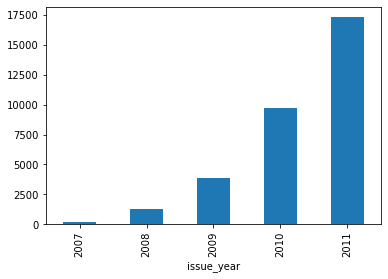

In [289]:
df.groupby('issue_year').id.count().plot.bar()

### Loan Status
Whether the loans are fully paid vs charged off

Fully Paid     27561
Charged Off     4845
Name: loan_status, dtype: int64

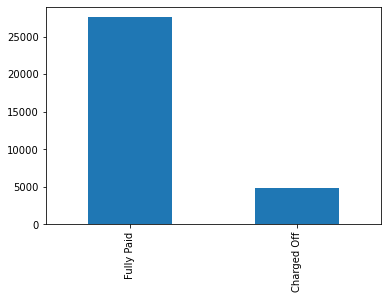

In [290]:
# number of loans fully paid vs charged off
df.loan_status.value_counts().plot.bar()
df.loan_status.value_counts()

### Loan Term
How long are the loans taken for. Majority of loans are of 36 months term.

 36 months    24513
 60 months     7893
Name: term, dtype: int64

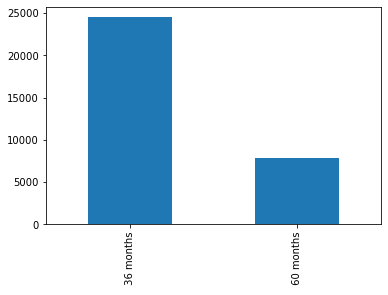

In [291]:
df.term.value_counts().plot.bar()
df.term.value_counts()

Fully Paid     0.850491
Charged Off    0.149509
Name: loan_status, dtype: float64

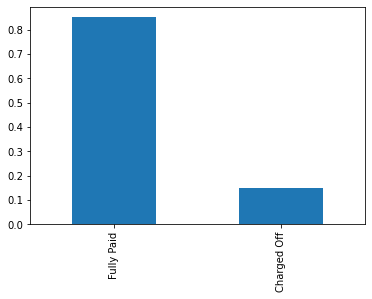

In [292]:
# percentage of loans fully paid vs charged off
df.loan_status.value_counts(normalize=True).plot.bar()
df.loan_status.value_counts(normalize=True)

### Loan Purpose
A category provided by the borrower for the loan request. Debt consolidation is the most popular category for loan requests.

debt_consolidation    15558
credit_card            4196
other                  3239
home_improvement       2140
major_purchase         1812
small_business         1412
car                    1280
wedding                 792
medical                 572
moving                  460
vacation                322
house                   301
educational             244
renewable_energy         78
Name: purpose, dtype: int64

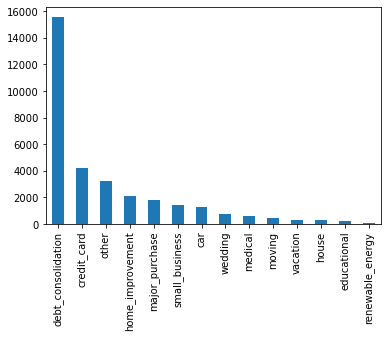

In [293]:
df.purpose.value_counts().plot.bar()
df.purpose.value_counts()

### Home Ownership
The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER. RENT being the most popular home ownership status amoung the borrowers.

RENT        16523
MORTGAGE    13354
OWN          2529
Name: home_ownership, dtype: int64

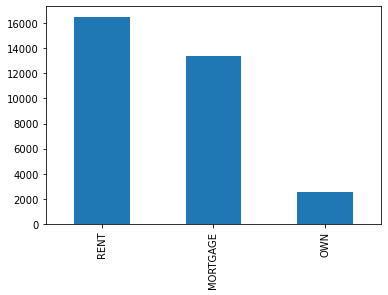

In [294]:
df.home_ownership.value_counts().plot.bar()
df.home_ownership.value_counts()

### Employment Length
The number of years the borrower has been employed for.

10+ years    6792
< 1 year     3748
2 years      3683
3 years      3418
4 years      2873
5 years      2763
1 year       2718
6 years      1870
7 years      1487
8 years      1191
9 years      1027
0 years       836
Name: emp_length, dtype: int64

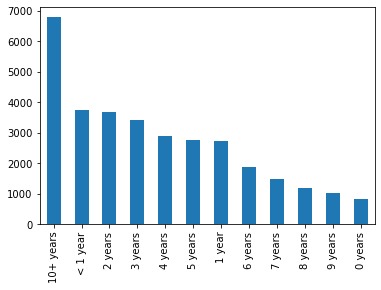

In [295]:
df.emp_length.value_counts().plot.bar()
df.emp_length.value_counts()

1-3 years    9819
4-6 years    7506
10+ years    6792
< 1 year     3748
6-9 years    3705
0 years       836
Name: emp_length_bands, dtype: int64

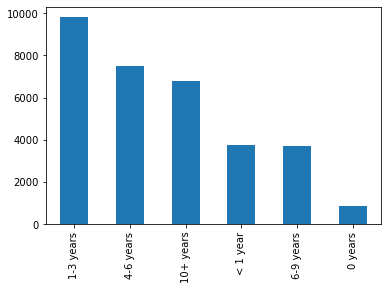

In [296]:
df['emp_length_bands'] = cut_bands(df.emp_length_years, [
    -np.inf, 0, 0.5, 3, 6, 9, 10
], ['0 years', '< 1 year', '1-3 years', '4-6 years', '6-9 years', '10+ years'])

df.emp_length_bands.value_counts().plot.bar()
df.emp_length_bands.value_counts()

### Loan Amount

The loan amount for 75% applications is < 15K. There are lesser applications for loan amounts beyond 15K.  

count    32406.000000
mean     10401.625471
std       6693.870032
min        500.000000
25%       5000.000000
50%       9000.000000
75%      14125.000000
max      35000.000000
Name: loan_amnt, dtype: float64

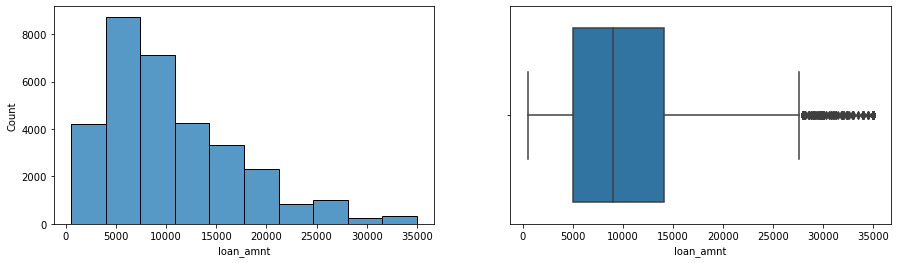

In [297]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='loan_amnt', bins=10, ax=axes[0])
sns.boxplot(df.loan_amnt, ax=axes[1])
df.loan_amnt.describe()

5k-10k     11457
0-5k        8177
10k-15k     6586
15k-20k     3524
20k-25k     1877
25k+         785
Name: loan_amnt_bands, dtype: int64

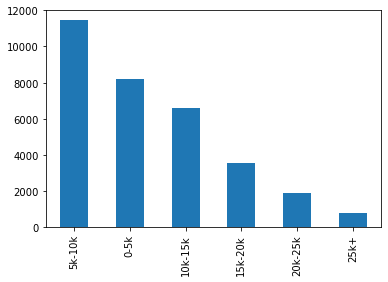

In [298]:
df['loan_amnt_bands'] = cut_bands(
    df.loan_amnt, [0, 5000, 10000, 15000, 20000, 25000, np.inf],
    ['0-5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k+'])

df.loan_amnt_bands.value_counts().plot.bar()
df.loan_amnt_bands.value_counts()

### Annual Income
Most people applying for loan have annual income in the range of 40K-70K.

count     32406.000000
mean      56246.946915
std       20805.524131
min       19000.000000
25%       40000.000000
50%       54000.000000
75%       71500.000000
max      103000.000000
Name: annual_inc, dtype: float64

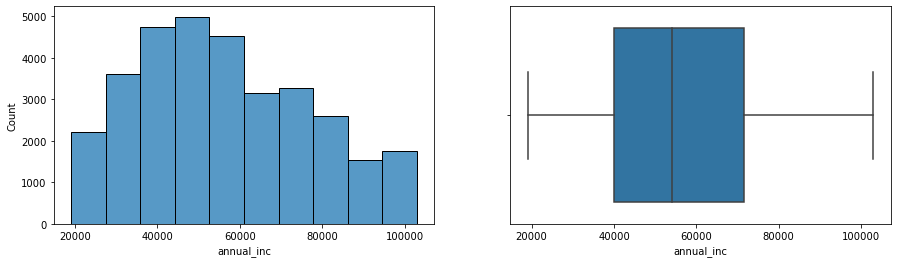

In [299]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='annual_inc', bins=10, ax=axes[0])
sns.boxplot(df.annual_inc, ax=axes[1])
df.annual_inc.describe()

40k-60k     11237
20k-40k      8493
60k-80k      7602
80k-100k     4498
100k+         292
0-20k         284
Name: annual_inc_bands, dtype: int64

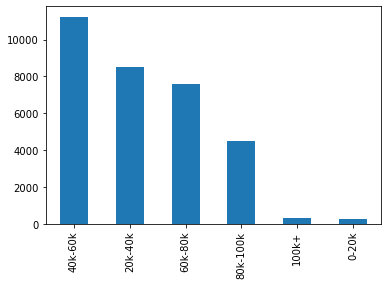

In [300]:
# create annual income bands
df['annual_inc_bands'] = cut_bands(
    df['annual_inc'], [0, 20000, 40000, 60000, 80000, 100000, np.inf],
    ['0-20k', '20k-40k', '40k-60k', '60k-80k', '80k-100k', '100k+'])

df.annual_inc_bands.value_counts().plot.bar()
df.annual_inc_bands.value_counts()

### Loan Amount as Times of Monthly Income (Dervied)
Determning the loan amount in terms of borrower's monthly income is a common practice to analyze their paying capability.

count    32406.000000
mean         2.340410
std          1.400087
min          0.101695
25%          1.258065
50%          2.058535
75%          3.157895
max          9.960000
Name: loan_amnt_by_mthly_inc, dtype: float64

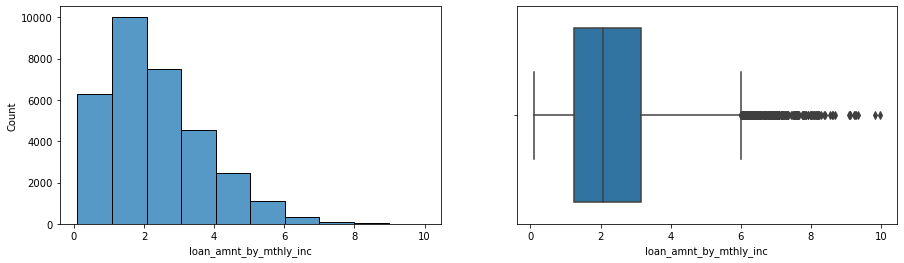

In [301]:
df['loan_amnt_by_mthly_inc'] = df.apply(
    lambda d: d.loan_amnt * 12 / d.annual_inc, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='loan_amnt_by_mthly_inc', bins=10, ax=axes[0])
sns.boxplot(df.loan_amnt_by_mthly_inc, ax=axes[1])
df.loan_amnt_by_mthly_inc.describe()

1-3 months    18033
3-6 months     8351
< 1 month      5551
6+ months       471
Name: loan_amnt_by_mthly_inc_bands, dtype: int64

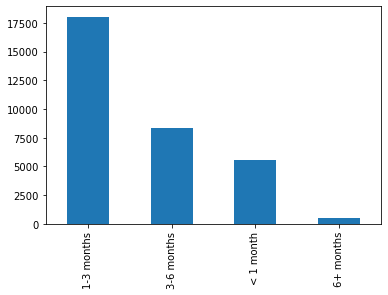

In [302]:
# create loan amount as time of monthly income bands
df['loan_amnt_by_mthly_inc_bands'] = cut_bands(df.loan_amnt_by_mthly_inc,
                                               [0, 1, 3, 6, np.inf], [
                                                   '< 1 month',
                                                   '1-3 months',
                                                   '3-6 months',
                                                   '6+ months',
                                               ])

df.loan_amnt_by_mthly_inc_bands.value_counts().plot.bar()
df.loan_amnt_by_mthly_inc_bands.value_counts()

### Instalment Amount
Most people have instalment amount between 150 and 400. But there are few loans with high instalment amount > 800.

count    32406.000000
mean       303.800385
std        188.348866
min         16.080000
25%        163.570000
50%        265.605000
75%        397.232500
max       1302.690000
Name: installment, dtype: float64

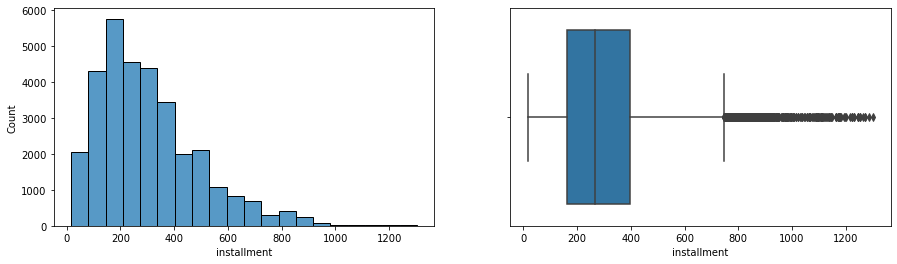

In [303]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='installment', bins=20, ax=axes[0])
sns.boxplot(df.installment, ax=axes[1])
df.installment.describe()

150-300    11580
300-450     7810
0-150       6659
450-600     3746
600+        2611
Name: installment_bands, dtype: int64

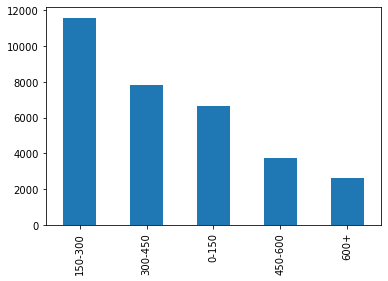

In [304]:
df['installment_bands'] = cut_bands(
    df.installment, [0, 150, 300, 450, 600, np.inf],
    ['0-150', '150-300', '300-450', '450-600', '600+'])
df.installment_bands.value_counts().plot.bar()
df.installment_bands.value_counts()

### Instalment Amount as Percent of Monthly Income (Derived)

We can drive the metric from instalment amount and annual income to analyze the paying capacity of the borrower.

count    32406.000000
mean         6.879477
std          4.021308
min          0.327051
25%          3.813011
50%          6.128322
75%          9.211078
max         32.026200
Name: installment_mthly_inc_prcnt, dtype: float64

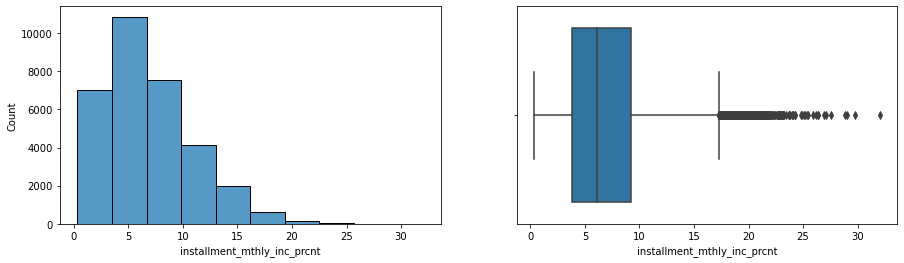

In [305]:
df['installment_mthly_inc_prcnt'] = df.apply(
    lambda d: d.installment * 12 * 100 / d.annual_inc, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='installment_mthly_inc_prcnt', bins=10, ax=axes[0])
sns.boxplot(df.installment_mthly_inc_prcnt, ax=axes[1])
df.installment_mthly_inc_prcnt.describe()

5-10 percent     13385
0-5 percent      12362
10-15 percent     5275
15-20 percent     1231
20+ percent        153
Name: installment_mthly_inc_prcnt_bands, dtype: int64

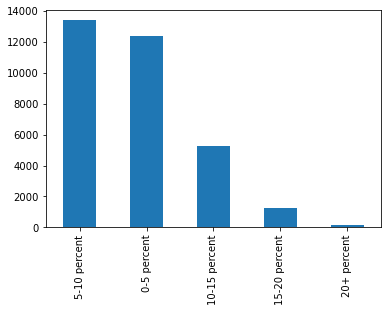

In [306]:
df['installment_mthly_inc_prcnt_bands'] = cut_bands(
    df.installment_mthly_inc_prcnt, [0, 5, 10, 15, 20, np.inf], [
        '0-5 percent', '5-10 percent', '10-15 percent', '15-20 percent',
        '20+ percent'
    ])
df.installment_mthly_inc_prcnt_bands.value_counts().plot.bar()
df.installment_mthly_inc_prcnt_bands.value_counts()

### Interest Rate

Most people are given loans on interest rate between 9% to 14% pa.

count    32406.000000
mean        11.854692
std          3.644973
min          5.420000
25%          8.900000
50%         11.710000
75%         14.270000
max         24.400000
Name: int_rate, dtype: float64

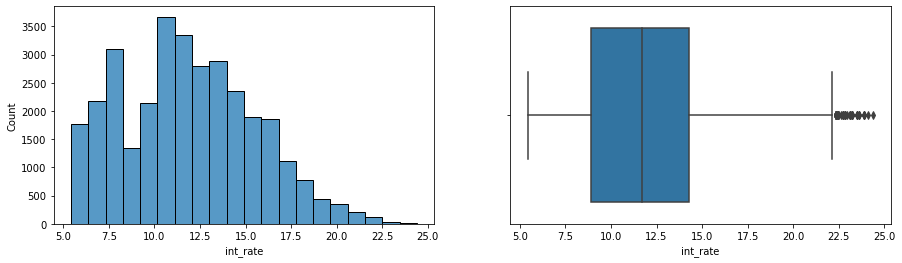

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='int_rate', bins=20, ax=axes[0])
sns.boxplot(df.int_rate, ax=axes[1])
df.int_rate.describe()

11-14 percent    9811
5-8 percent      7030
8-11 percent     6852
14-17 percent    5951
17+ percent      2762
Name: int_rate_bands, dtype: int64

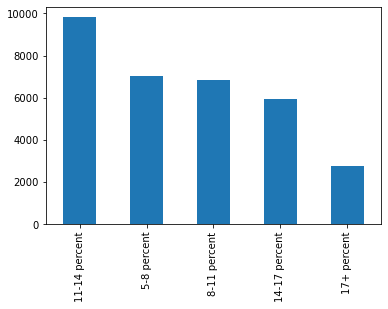

In [308]:
df['int_rate_bands'] = cut_bands(df.int_rate, [5, 8, 11, 14, 17, np.inf], [
    '5-8 percent', '8-11 percent', '11-14 percent', '14-17 percent',
    '17+ percent'
])

df.int_rate_bands.value_counts().plot.bar()
df.int_rate_bands.value_counts()

### Debt to Income
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

count    32406.000000
mean        13.662662
std          6.663784
min          0.000000
25%          8.600000
50%         13.860000
75%         18.970000
max         29.990000
Name: dti, dtype: float64

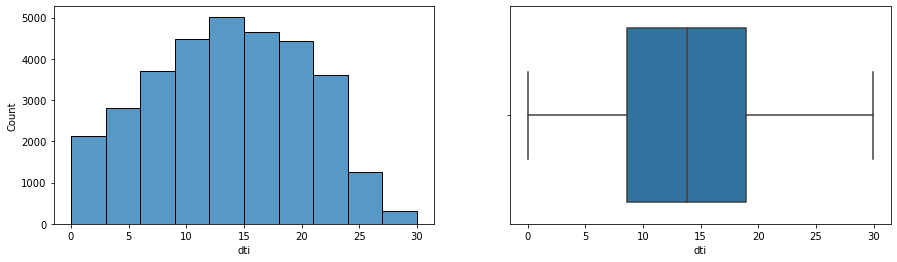

In [309]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='dti', bins=10, ax=axes[0])
sns.boxplot(df.dti, ax=axes[1])
df.dti.describe()

10-20 percent    15756
0-10 percent      9974
20-30 percent     6549
Name: dti_bands, dtype: int64

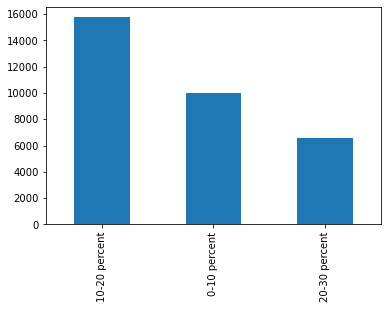

In [310]:
df['dti_bands'] = cut_bands(df.dti, [0, 10, 20, 30],
                            ['0-10 percent', '10-20 percent', '20-30 percent'])

df.dti_bands.value_counts().plot.bar()
df.dti_bands.value_counts()

### Total Debt to Income Including LC Loan Instalment (Derived)

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, including the requested LC loan, divided by the borrower’s self-reported monthly income.

count    32406.000000
mean        20.542140
std          8.181698
min          0.651432
25%         14.511307
50%         20.573359
75%         26.496740
max         42.962894
Name: tdti, dtype: float64

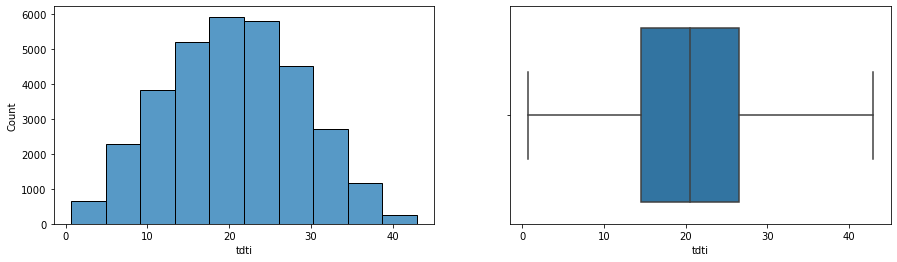

In [311]:
df['tdti'] = df.apply(lambda d: d.dti + d.installment_mthly_inc_prcnt, axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='tdti', bins=10, ax=axes[0])
sns.boxplot(df.tdti, ax=axes[1])
df.tdti.describe()

20-30 percent    12660
10-20 percent    11725
30-40 percent     4346
0-10 percent      3639
40+ percent         36
Name: tdti_bands, dtype: int64

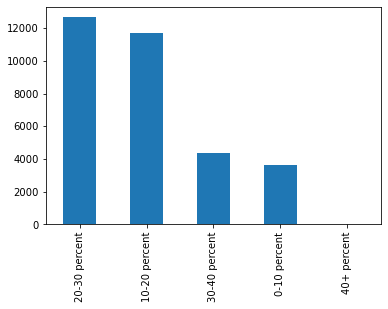

In [312]:
df['tdti_bands'] = cut_bands(df.tdti, [0, 10, 20, 30, 40, np.inf], [
    '0-10 percent', '10-20 percent', '20-30 percent', '30-40 percent',
    '40+ percent'
])

df.tdti_bands.value_counts().plot.bar()
df.tdti_bands.value_counts()

### Pending Principal Amount Percentage (Derived)

We can culculate the percentage of pending loan principal amount for charged off account to analyze at what stage borrowers stop paying the loan. Most of the defaulters don't pay 50-85% of the loan amount. 

count    4845.000000
mean       64.970768
std        24.490056
min         1.155417
25%        47.190833
50%        70.225317
75%        85.607033
max       100.000000
Name: pending_prncp_prcnt, dtype: float64

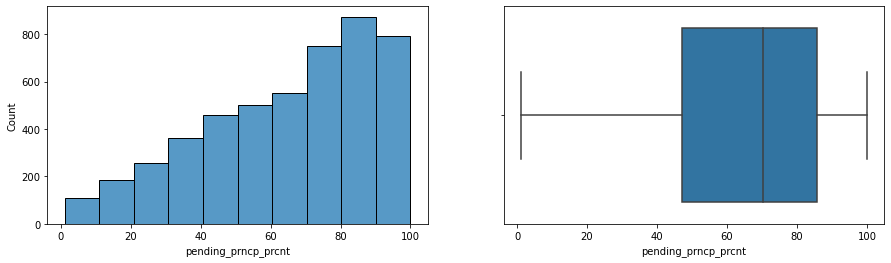

In [313]:
df['pending_prncp_prcnt'] = df.apply(
    lambda d: (d.loan_amnt - d.total_rec_prncp) * 100 / d.loan_amnt
    if d.charged_off == 1 else 0,
    axis=1)

df_charged_off = df[df.charged_off == 1]
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df_charged_off, x='pending_prncp_prcnt', bins=10, ax=axes[0])
sns.boxplot(df_charged_off.pending_prncp_prcnt, ax=axes[1])
df_charged_off.pending_prncp_prcnt.describe()

75-100 percent    2075
50-75 percent     1427
25-50 percent      947
0-25 percent       396
Name: pending_prncp_prcnt_bands, dtype: int64

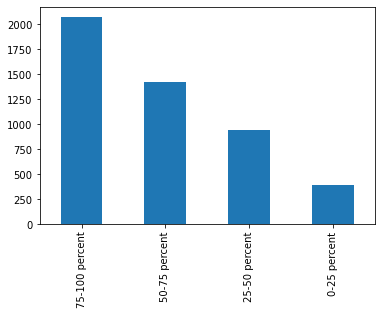

In [314]:
df['pending_prncp_prcnt_bands'] = cut_bands(
    df.pending_prncp_prcnt, [0, 25, 50, 75, 100],
    ['0-25 percent', '25-50 percent', '50-75 percent', '75-100 percent'])

df.pending_prncp_prcnt_bands.value_counts().plot.bar()
df.pending_prncp_prcnt_bands.value_counts()

### Inquiries in Last 6 Months
The number of inquiries in past 6 months (excluding auto and mortgage inquiries).

count    32406.000000
mean         0.859563
std          1.060227
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64

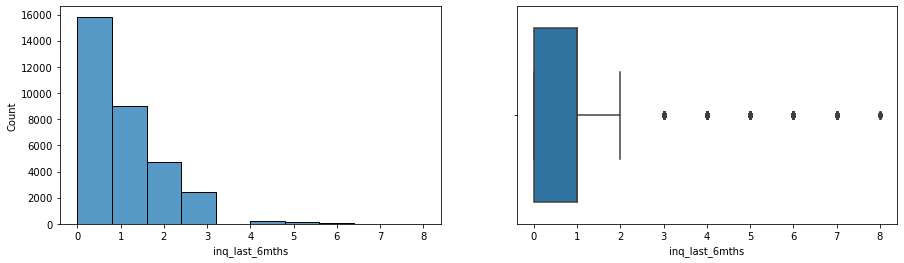

In [315]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='inq_last_6mths', bins=10, ax=axes[0])
sns.boxplot(df.inq_last_6mths, ax=axes[1])
df.inq_last_6mths.describe()

0 times     15826
1 times      8984
2 times      4697
2+ times     2899
Name: inq_last_6mths_bands, dtype: int64

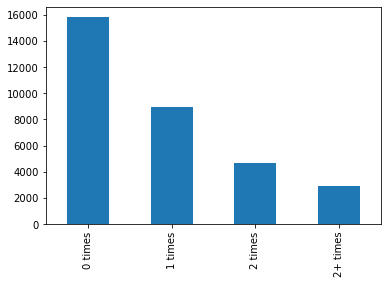

In [316]:
df['inq_last_6mths_bands'] = cut_bands(df.inq_last_6mths,
                                       [-np.inf, 0, 1, 2, np.inf], [
                                           '0 times',
                                           '1 times',
                                           '2 times',
                                           '2+ times',
                                       ])

df.inq_last_6mths_bands.value_counts().plot.bar()
df.inq_last_6mths_bands.value_counts()

### Months Since Borrower's Last Delinquency

The number of months since the borrower's last delinquency.

count    11451.000000
mean        36.349140
std         22.045432
min          0.000000
25%         19.000000
50%         35.000000
75%         53.000000
max        120.000000
Name: mths_since_last_delinq, dtype: float64

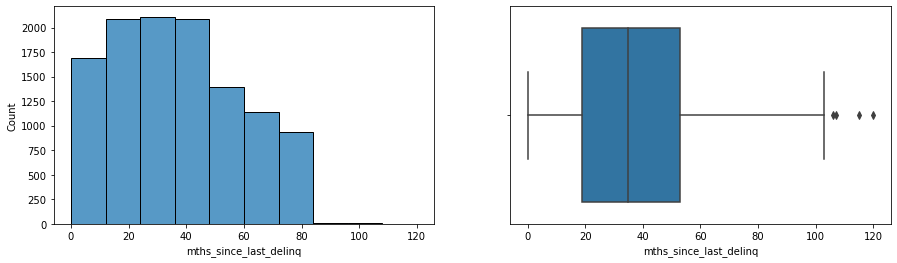

In [317]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='mths_since_last_delinq', bins=10, ax=axes[0])
sns.boxplot(df.mths_since_last_delinq, ax=axes[1])
df.mths_since_last_delinq.describe()

48+ months      3319
12-24 months    2134
24-36 months    2084
36-48 months    2080
0-12 months     1469
0 months         365
Name: mths_since_last_delinq_bands, dtype: int64

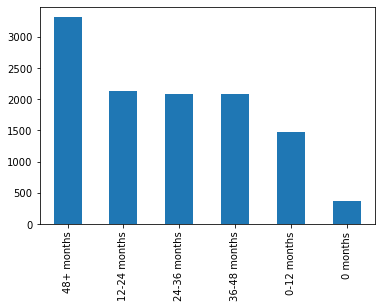

In [318]:
df['mths_since_last_delinq_bands'] = cut_bands(
    df.mths_since_last_delinq, [-np.inf, 0, 12, 24, 36, 48, np.inf], [
        '0 months', '0-12 months', '12-24 months', '24-36 months',
        '36-48 months', '48+ months'
    ])

df.mths_since_last_delinq_bands.value_counts().plot.bar()
df.mths_since_last_delinq_bands.value_counts()

### Having Delinquency History (Derived)
Assuming borrowers for whom `mths_since_last_delinq` variable has value `0`, has no deliquency history.

False    0.64664
True     0.35336
Name: delinq_history, dtype: float64

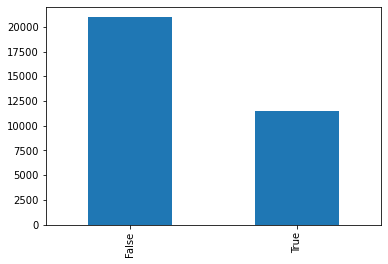

In [319]:
# create boolean column for if borrower was ever a defauler
df['delinq_history'] = ~df.mths_since_last_delinq.isnull()

df.delinq_history.value_counts().plot.bar()
df.delinq_history.value_counts(normalize=True)

### Months Since Borrower's Earlist Credit Line Opened (Derived)

The number of months since the borrower's earliest credit line was opened at the time of loan was issued.

count    32406.000000
mean       159.605875
std         79.947801
min         36.000000
25%        105.000000
50%        145.000000
75%        196.000000
max        785.000000
Name: mths_since_earliest_cr_line, dtype: float64

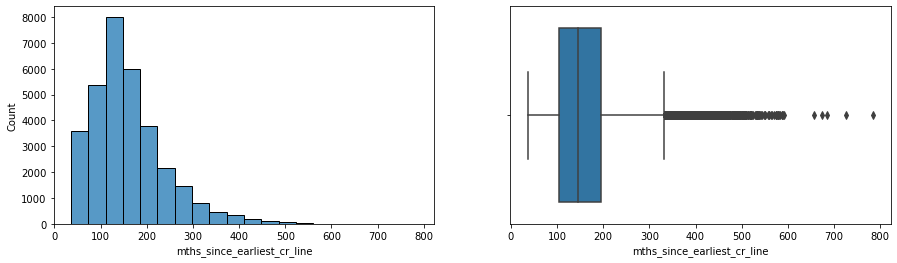

In [320]:
# find how long the earliest credit line was avaialble at the time of loan issue
df['mths_since_earliest_cr_line'] = df.apply(lambda d: np.round(
    (d.issue_date - d.earliest_cr_line_date).days * 12 / 365),
                                             axis=1)

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(df, x='mths_since_earliest_cr_line', bins=20, ax=axes[0])
sns.boxplot(df.mths_since_earliest_cr_line, ax=axes[1])
df.mths_since_earliest_cr_line.describe()

9-12 years     7489
12-15 years    6183
18+ years      6122
6-9 years      5173
15-18 years    3982
3-6 years      3443
3 years          14
Name: mths_since_earliest_cr_line_bands, dtype: int64

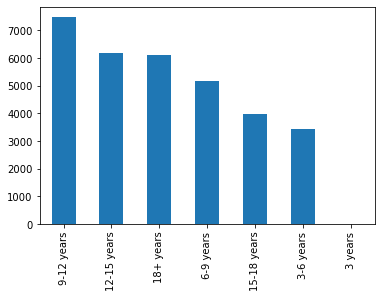

In [321]:
df['mths_since_earliest_cr_line_bands'] = cut_bands(
    df.mths_since_earliest_cr_line,
    [-np.inf, 36, 72, 108, 144, 180, 216, np.inf], [
        '3 years', '3-6 years', '6-9 years', '9-12 years', '12-15 years',
        '15-18 years', '18+ years'
    ])

df.mths_since_earliest_cr_line_bands.value_counts().plot.bar()
df.mths_since_earliest_cr_line_bands.value_counts()

### Income Verification Status
Indicates if income was verified by LC, not verified, or if the income source was verified. For about 50% of the loans the borrower's income is not verified.

Not Verified       14769
Verified            9462
Source Verified     8175
Name: verification_status, dtype: int64

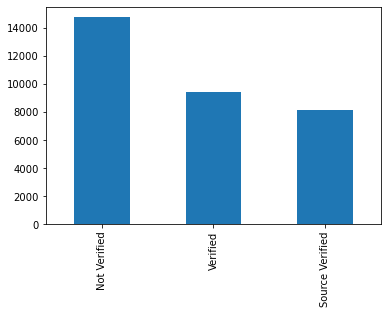

In [322]:
df.verification_status.value_counts().plot.bar()
df.verification_status.value_counts()

### Loan Grade
Grade assigned by LC. "B" being the most popular grade assigned by LC. While A4, B3, A5, B4 are top sub grades.

B    9884
A    8553
C    6649
D    4268
E    2110
F     742
G     200
Name: grade, dtype: int64

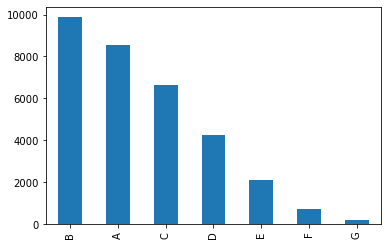

In [323]:
# LC assigned grade
df.grade.value_counts().plot.bar()
df.grade.value_counts()

A4    2456
B3    2362
A5    2268
B5    2236
B4    2056
Name: sub_grade, dtype: int64

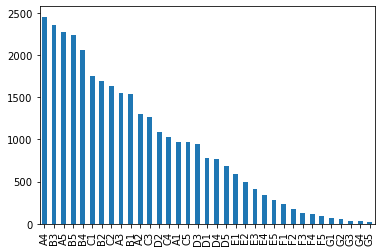

In [324]:
# LC assigned sub grade
df.sub_grade.value_counts().plot.bar()
df.sub_grade.value_counts().head()

## Bivariate Analysis
Below we compare charged off loan percentage for various groups. The mean charged off loan percentage is 14.95%.

### Correlation Metrix
- Annual icome strongly co-related with loan amount.
- Interest rate slightly co-relates with percentage of pending principal loan amount for charged-off loans.
- Term of loan slightly co-relates with interest rate and percentage of pending principal loan amount for charged-off loans.
- Employment length slightly co-relates with annual income.

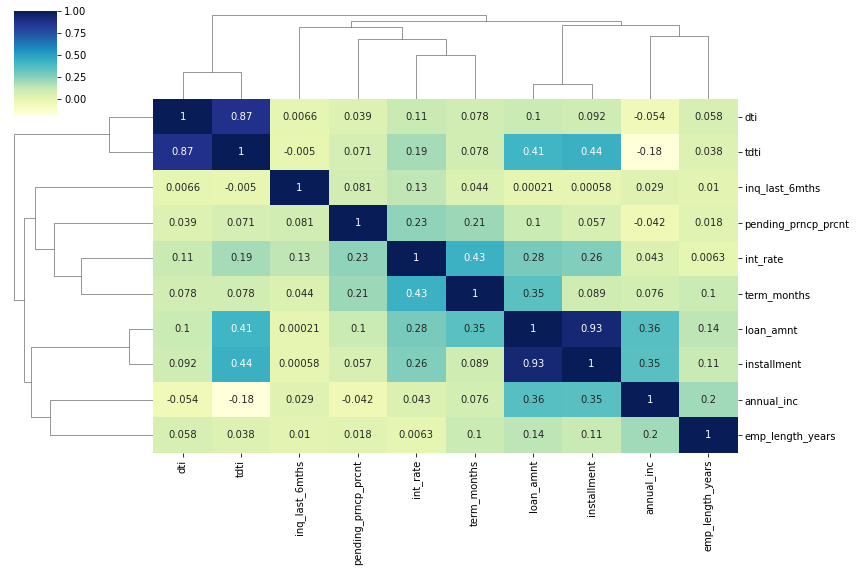

In [325]:
sns.clustermap(df[[
    'annual_inc', 'loan_amnt', 'int_rate', 'inq_last_6mths', 'installment',
    'dti', 'tdti', 'term_months', 'emp_length_years', 'pending_prncp_prcnt'
]].corr(),
               annot=True,
               figsize=(12, 8),
               cmap="YlGnBu")

### Loan Purpose VS Charged Off Loan Percentage
Borrowers taking loan for the purpose of supporting their small business are highly likely to not be able to repay the loan as their charged off loan percentage is 28.5%.

purpose
car                   10.859375
credit_card           11.224976
debt_consolidation    15.702532
educational           16.803279
home_improvement      13.457944
house                 15.946844
major_purchase        10.540839
medical               15.559441
moving                16.739130
other                 15.838222
renewable_energy      19.230769
small_business        28.541076
vacation              14.285714
wedding               10.227273
dtype: float64

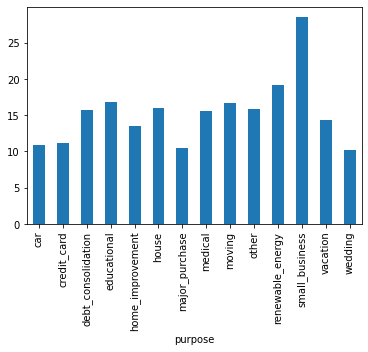

In [326]:
cop = get_charged_off_percent(df.groupby('purpose'))
cop.plot.bar()
cop

### Loan Purpose VS  Percentage of Pending Principal Loan Amount
For charged off loan accounts, it can be seen that house loans have the highest mean percentage of pending principal loan amount i.e. 70.5% followed by Small Business & Wedding Loands at 68%.

purpose
house                 70.559842
small_business        68.765879
wedding               68.256214
medical               66.520286
debt_consolidation    65.750544
other                 65.079508
renewable_energy      64.495885
home_improvement      63.557528
major_purchase        62.599706
vacation              62.297992
credit_card           62.004371
moving                59.956371
car                   57.507251
educational           56.389177
Name: pending_prncp_prcnt, dtype: float64

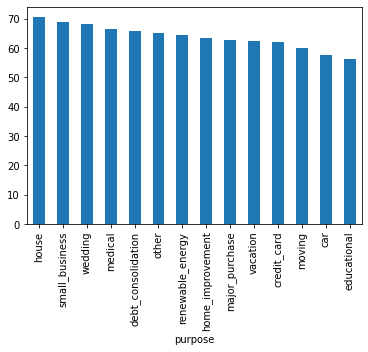

In [327]:
df[df.charged_off == 1].groupby('purpose').pending_prncp_prcnt.mean(
).sort_values(ascending=False).plot.bar()
df[df.charged_off == 1].groupby(
    'purpose').pending_prncp_prcnt.mean().sort_values(ascending=False)

<AxesSubplot:xlabel='pending_prncp_prcnt', ylabel='purpose'>

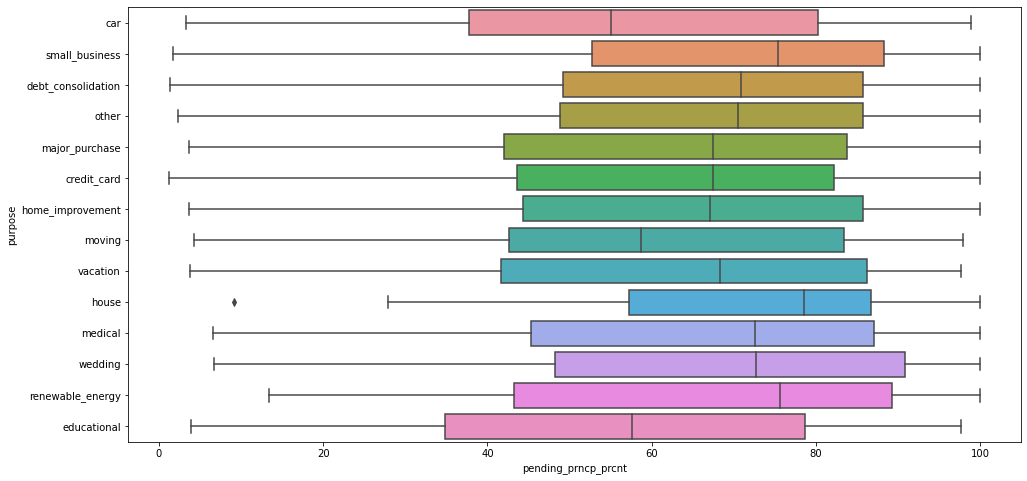

In [328]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='pending_prncp_prcnt',
            y='purpose',
            data=df[df.charged_off == 1],
            ax=ax)

### Home Ownership VS Charged Off Loan Percentage
The home ownership status does not seem to create an impact of the possibility of full repayment of the loan.

home_ownership
MORTGAGE    14.602366
OWN         15.183867
RENT        15.196998
dtype: float64

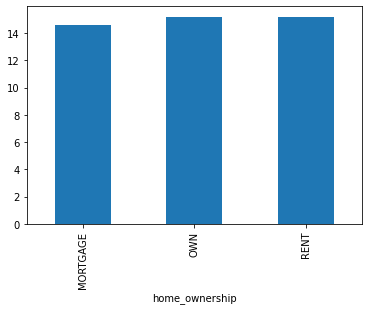

In [329]:
cop = get_charged_off_percent(df.groupby('home_ownership'))
cop.plot.bar()
cop

### Home Ownership VS Interest Rates
Irrespective of home ownership status, loans are funded at similar interest rates.

<AxesSubplot:xlabel='int_rate', ylabel='home_ownership'>

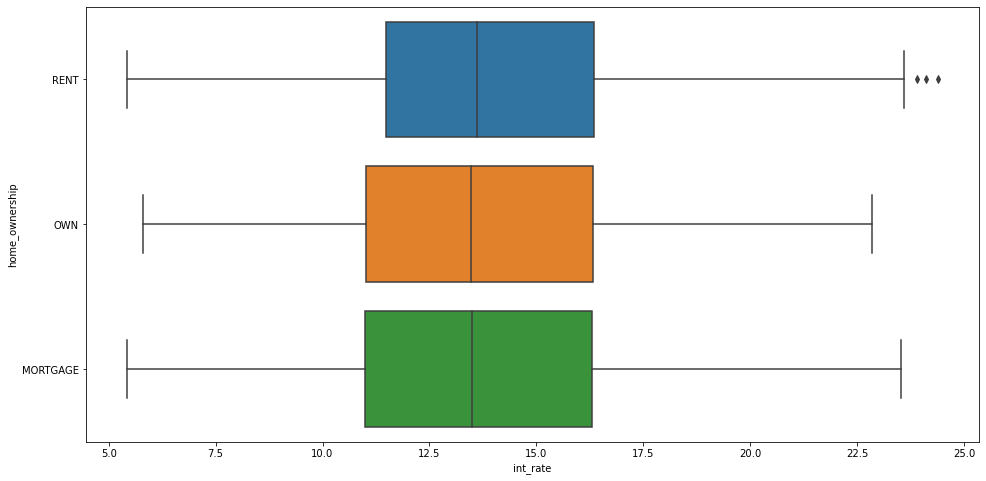

In [330]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='int_rate',
            y='home_ownership',
            data=df[df.charged_off == 1],
            ax=ax)

### Employment Length VS Charged Off Percentage
Borrowers having no employment length record are very likely to go delinquent with charged off loan percentage being 21.77%.

emp_length_bands
0 years      21.770335
< 1 year     14.274280
1-3 years    13.871066
4-6 years    14.321876
6-9 years    14.709852
10+ years    16.872792
dtype: float64

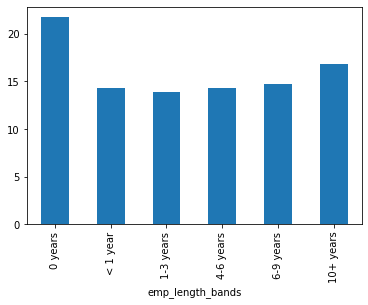

In [331]:
cop = get_charged_off_percent(df.groupby('emp_length_bands'))
cop.plot.bar()
cop

### Employment Length VS Loan Amount and Interest Rates
Interest rates and loan amounts increases on average with increasing empployement length.

Borrowers having no employment length record are known to be highly risky even when it can be seen that they are provided small amount loans at lower interest rates than others.

<AxesSubplot:xlabel='int_rate', ylabel='emp_length_bands'>

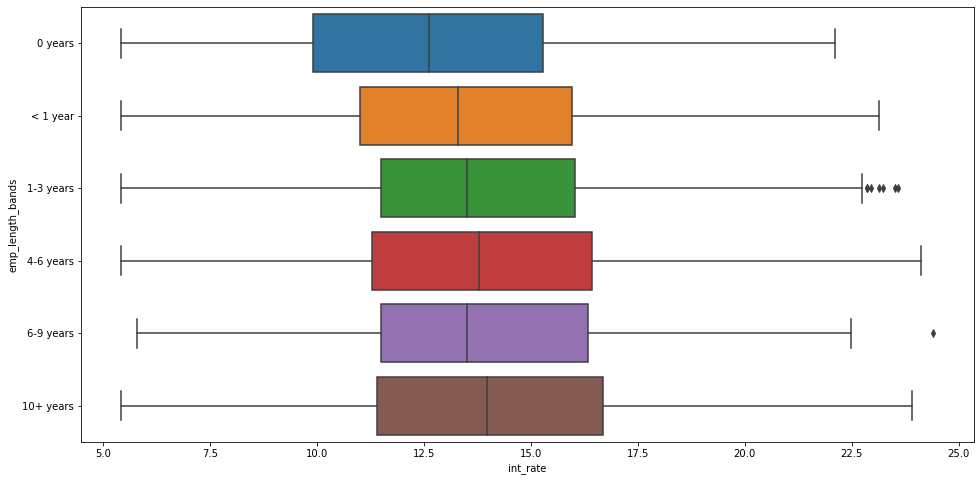

In [332]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='int_rate',
            y='emp_length_bands',
            data=df[df.charged_off == 1],
            ax=ax)

<AxesSubplot:xlabel='loan_amnt', ylabel='emp_length_bands'>

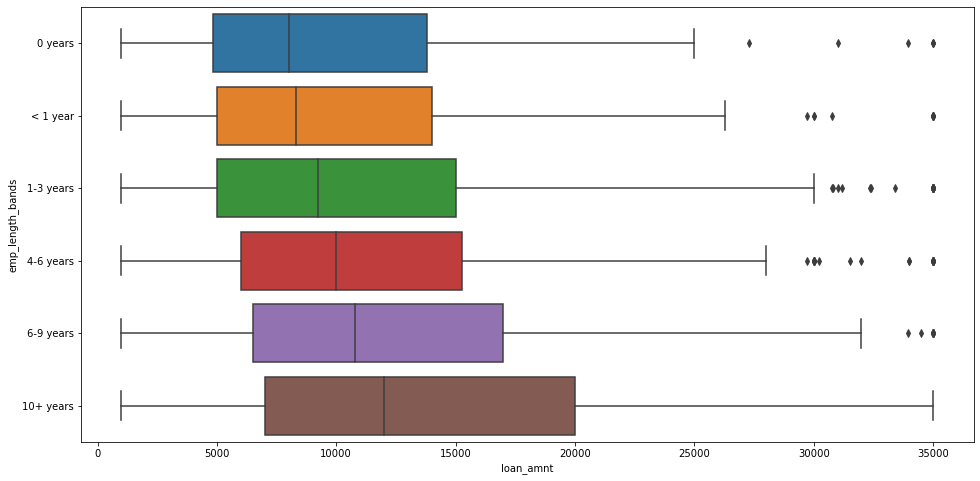

In [333]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='loan_amnt',
            y='emp_length_bands',
            data=df[df.charged_off == 1],
            ax=ax)

### Loan Amount VS Charged Off Percentage
The borrowers applying for higher loan amounts are more likely to not repay. Loans > 20K are at a larger risk with >21% charged off loans percentage.

loan_amnt_bands
0-5k       13.574661
5k-10k     12.987693
10k-15k    14.591558
15k-20k    19.040863
20k-25k    21.310602
25k+       27.388535
dtype: float64

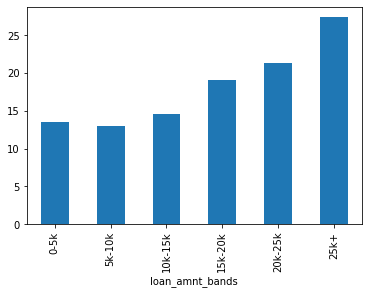

In [334]:
cop = get_charged_off_percent(df.groupby('loan_amnt_bands'))
cop.plot.bar()
cop

### Loan Amount VS Loan Purpose
 The highest total amount is funded to debt consolidation loans. While small business, house, debt consolidation loans have the highest mean loan amount overall.

<AxesSubplot:xlabel='loan_amnt', ylabel='purpose'>

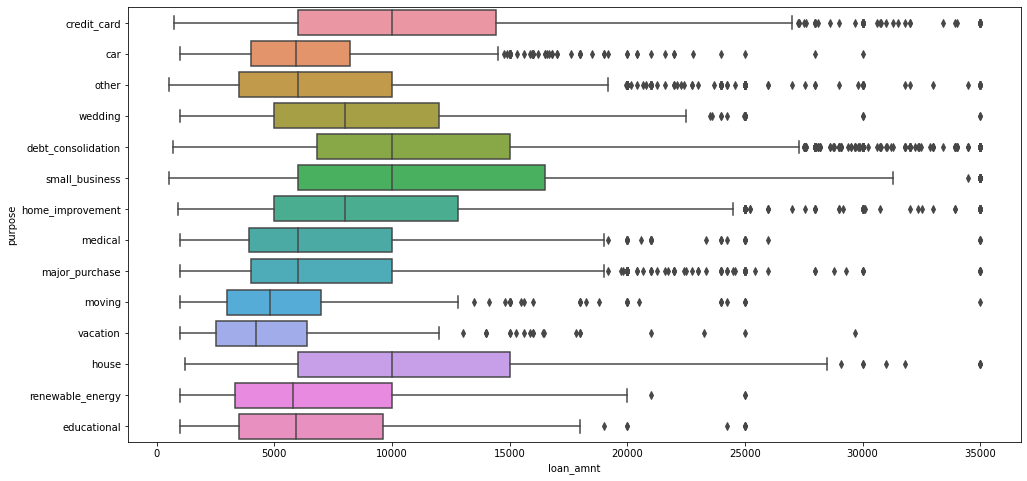

In [335]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='loan_amnt', y='purpose', data=df, ax=ax)

### Loan Term VS Charged Off Loan Percentage
60 months loans are highly risky with charged off loan percentage at 26.4%.

term
 36 months    11.259332
 60 months    26.415811
dtype: float64

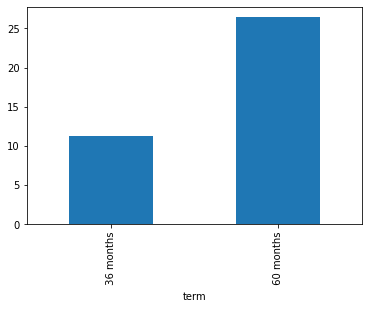

In [336]:
cop = get_charged_off_percent(df.groupby('term'))
cop.plot.bar()
cop

### Loan Term VS Loan Amount
The 60 months loan duration itself might not cause the higher charged off loan percentage. But below we can see that 60 months loans are of much higher amount and higher amount loans are known to be more risky.

<AxesSubplot:xlabel='loan_amnt', ylabel='term'>

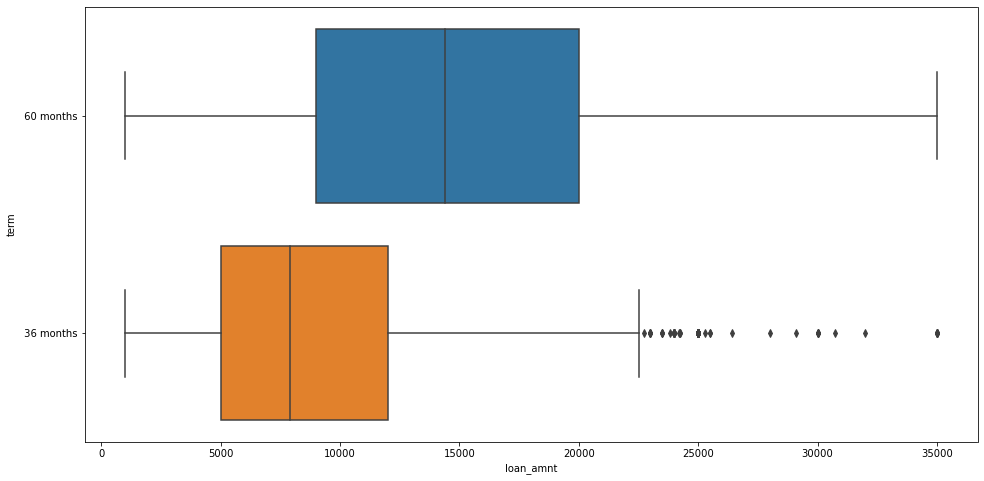

In [337]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='loan_amnt',
            y='term',
            data=df[df.charged_off == 1],
            ax=ax)

### Loan Term VS Interest Rate
60 months loans are funded at much higher interest rates which may cause them to be more risky.

<AxesSubplot:xlabel='int_rate', ylabel='term'>

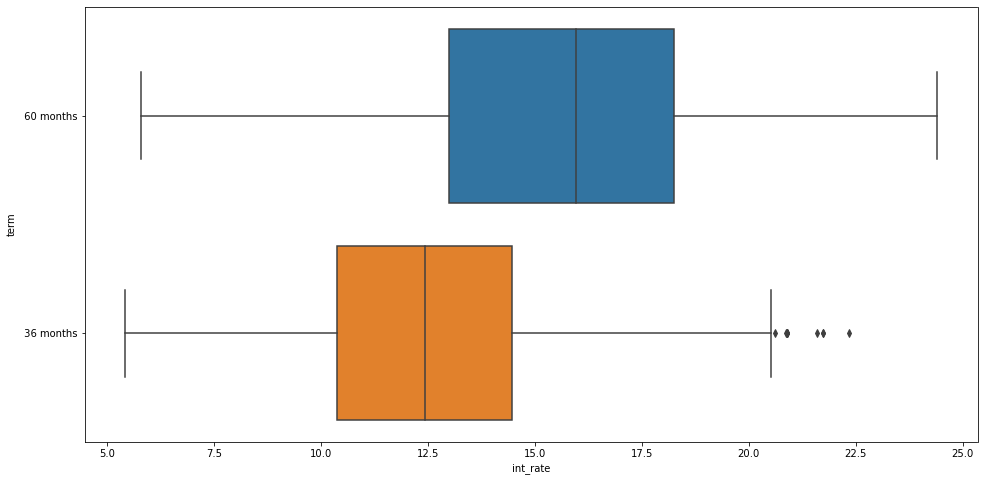

In [338]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='int_rate',
            y='term',
            data=df[df.charged_off == 1],
            ax=ax)

### Annual Income VS Charged Off Percentage
The borrowers having income between 20K-40K are more likely to not repay the loan compared to other income bands as there is a relatively much higher charge off loan percentage i.e. 17.76%.

annual_inc_bands
0-20k       12.323944
20k-40k     17.755799
40k-60k     15.351072
60k-80k     13.404367
80k-100k    11.760783
100k+        9.931507
dtype: float64

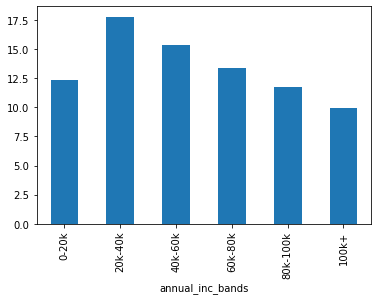

In [339]:
cop = get_charged_off_percent(df.groupby('annual_inc_bands'))
cop.plot.bar()
cop

### Loan Amount as Times of Monthly Income  VS Charged Off Percentage
From the below analysis we can see that loans where the total lending amount is < 3 months of borrower's income are very safe to give with charged off percentage being 12%-13% only.

While loans > 6 months of borrower's monthly income are very risky of delinquency as the charged off percentage for such loans is 31.6%.

loan_amnt_by_mthly_inc_bands
< 1 month     11.907764
1-3 months    12.959574
3-6 months    20.332894
6+ months     31.634820
dtype: float64

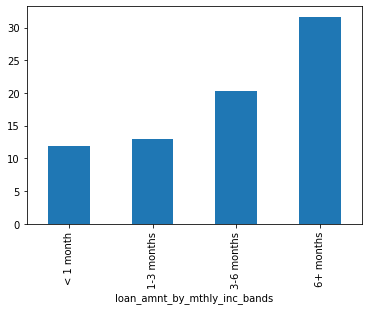

In [340]:
cop = get_charged_off_percent(df.groupby('loan_amnt_by_mthly_inc_bands'))
cop.plot.bar()
cop

### Instalment Amount VS Charged Off Percentage
Loans with monthly instalment amount > 600 are at a higher risk of delinquency with charged off loan percentage being 18.88%. The charged off loan percentage increases linearly with increase in monthly instalment amount.

installment_bands
0-150      13.951044
150-300    13.886010
300-450    15.134443
450-600    16.898025
600+       18.881655
dtype: float64

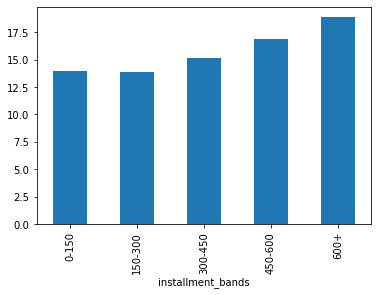

In [341]:
cop = get_charged_off_percent(df.groupby('installment_bands'))
cop.plot.bar()
cop

### Instalment Amount as Percent of Monthly Income VS Charged Off Percentage
The charged off percentage increases with increase in percentage of borrower's monthly income spent as loan installment.

Borrowers paying 15-20 percent of their monthly income as instalment are more likely to not be able to repay their loans with charged off loan percentage being 21.69%.

installment_mthly_inc_prcnt_bands
0-5 percent      12.433263
5-10 percent     14.792678
10-15 percent    19.545024
15-20 percent    21.689683
20+ percent      19.607843
dtype: float64

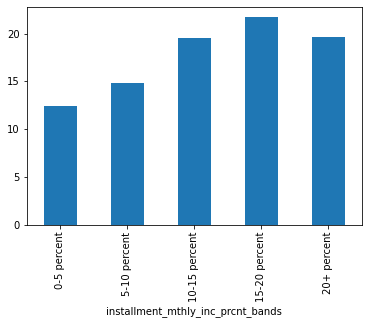

In [342]:
cop = get_charged_off_percent(df.groupby('installment_mthly_inc_prcnt_bands'))
cop.plot.bar()
cop

### Interest Rate VS Charged Off Percentage

Interest rate causes a significant impact on the percentage of charged off loans. Interest rate between 5-8% have a very healthy repayment percentage of 94.4% as 5.6% loans were charged off.

But as the interest rate is increased the charged off loans percentage increases significantly to as high as 33% for 17+ percent interest rate.

int_rate_bands
5-8 percent       5.604552
8-11 percent     10.712201
11-14 percent    15.829171
14-17 percent    21.055285
17+ percent      32.983345
dtype: float64

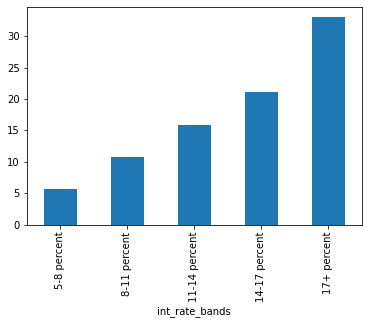

In [343]:
cop = get_charged_off_percent(df.groupby('int_rate_bands'))
cop.plot.bar()
cop

### Debt to Income VS Charged Off Percentage

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

Borrowers having already paying 20-30 percent of their monthly income as other debt obligations are slightly at more risk of not be able to repay the loan.

dti_bands
0-10 percent     13.124123
10-20 percent    15.352881
20-30 percent    16.811727
dtype: float64

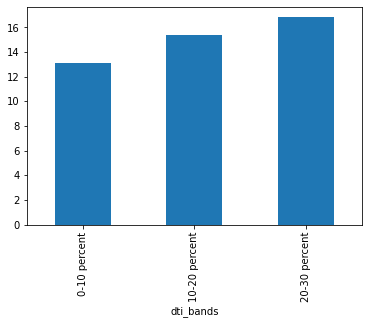

In [344]:
cop = get_charged_off_percent(df.groupby('dti_bands'))
cop.plot.bar()
cop

### Debt to Income VS Loan Amount
Though the difference between the charged off loan percentage for the 3 dti bands is not huge but gradualy increasing with increase in dti. 

We can see that borrowers who are already paying higher percentage of their monthly income as debt obligations are taking even higher loans. This results them into spending even larger amount each month and saving less, leading to higher charged off loan percentage. 

<AxesSubplot:xlabel='loan_amnt', ylabel='dti_bands'>

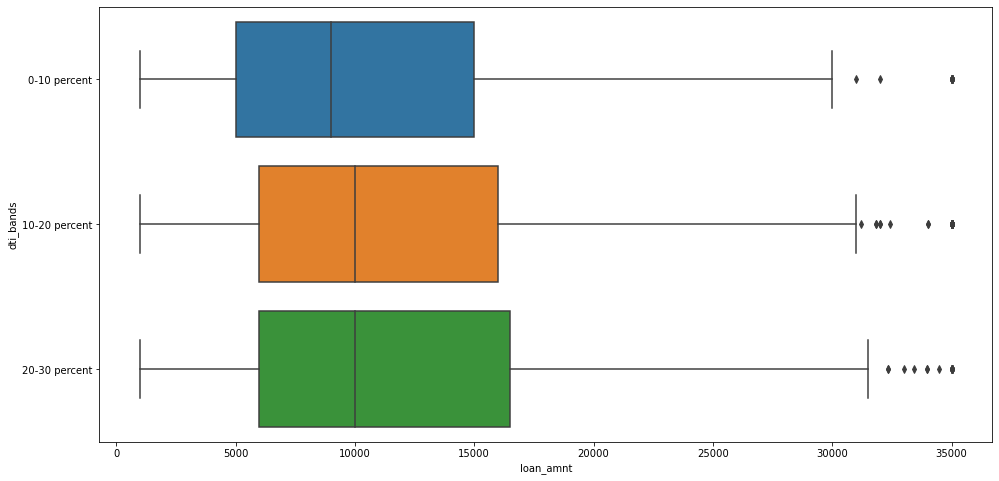

In [345]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='loan_amnt', y='dti_bands', data=df[df.charged_off == 1], ax=ax)

### Total Debt to Income Including LC Loan Instalment VS Charged Off Percentage

A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, including the requested LC loan, divided by the borrower’s self-reported monthly income.

Borrowers who have less savings as a result of paying 30-40 percent of their monthly income into debt obligations including the loan taken from LC have 19.2% of charged off loan percentage which is higher than 14.95% mean percentage.

tdti_bands
0-10 percent     11.843913
10-20 percent    13.049041
20-30 percent    16.153239
30-40 percent    19.236079
40+ percent       8.333333
dtype: float64

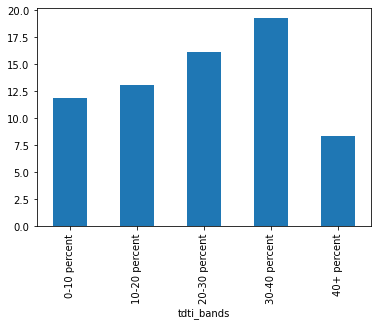

In [346]:
cop = get_charged_off_percent(df.groupby('tdti_bands'))
cop.plot.bar()
cop

### Inquiries in Last 6 Months VS Charged Off Loan Percentage

Borrowers who have made more than twice loan inquiries in last 6 months are much more likely to be delinquent as their charged off percentage is > 21%

inq_last_6mths_bands
0 times     12.460508
1 times     16.273375
2 times     16.968278
2+ times    21.179717
dtype: float64

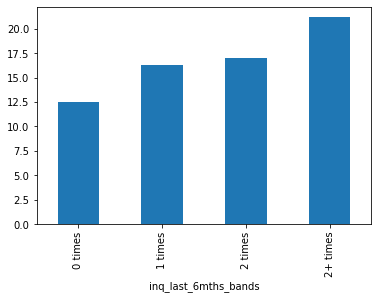

In [347]:
cop = get_charged_off_percent(df.groupby('inq_last_6mths_bands'))
cop.plot.bar()
cop

### Inquiries in Last 6 Months VS Loan Purpose

A lot of borrowers who have made more than twice loan inquiries in last 6 months apply for debt consolidation loan.

In [348]:
df[df.inq_last_6mths_bands == '2+ times'].purpose.value_counts()

debt_consolidation    1235
other                  339
home_improvement       304
credit_card            262
small_business         200
major_purchase         147
car                    116
wedding                 78
house                   67
medical                 50
moving                  38
vacation                31
educational             29
renewable_energy         3
Name: purpose, dtype: int64

### Months Since Borrower's Last Delinquency VS Charged Off Loan Percentage

Based on the below analysis the number of months since the borrower's last delinquency does not seem to create a much significant impact onf the charged off loans rate.

mths_since_last_delinq_bands
0 months        15.068493
0-12 months     16.746086
12-24 months    16.822868
24-36 months    13.771593
36-48 months    16.105769
48+ months      17.113588
dtype: float64

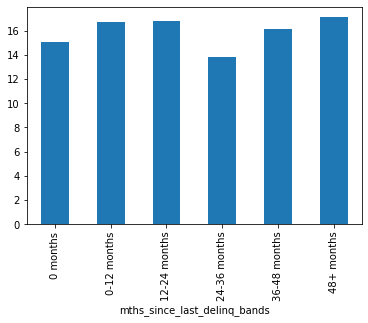

In [349]:
cop = get_charged_off_percent(df.groupby('mths_since_last_delinq_bands'))
cop.plot.bar()
cop

### Having Delinqency History VS Charged Off Percentage

Borrowers having delinquency history are relatively more likely to not repay loans.

delinq_history
False    14.292532
True     16.155794
dtype: float64

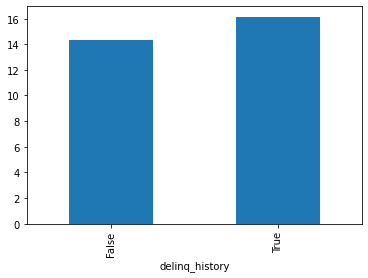

In [350]:
cop = get_charged_off_percent(df.groupby('delinq_history'))
cop.plot.bar()
cop

### Having Delinquency History VS Loan Purpose
Most of the borrowers having delinquency history take debt consolidation loan.

debt_consolidation    5410
other                 1271
credit_card           1242
home_improvement       834
major_purchase         658
small_business         532
car                    429
wedding                299
medical                218
moving                 189
vacation               128
house                  110
educational            101
renewable_energy        30
Name: purpose, dtype: int64

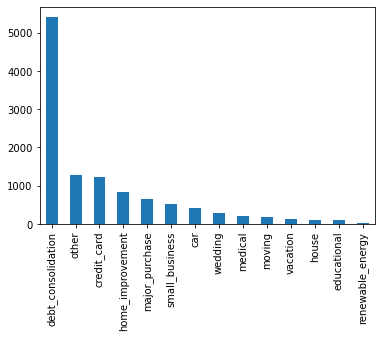

In [351]:
df[df.delinq_history == 1].purpose.value_counts().sort_values(
    ascending=False).plot.bar()
df[df.delinq_history == 1].purpose.value_counts().sort_values(ascending=False)

### Having Delinquency History VS Loan Amount
Most of the borrowers having delinquency history are given/requested small amount loans < 10K.

5k-10k     1488
0-5k       1110
10k-15k     961
15k-20k     671
20k-25k     400
25k+        215
Name: loan_amnt_bands, dtype: int64

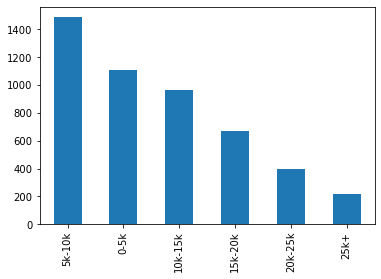

In [352]:
df[df.charged_off == 1].loan_amnt_bands.value_counts().sort_values(
    ascending=False).plot.bar()
df[df.charged_off == 1].loan_amnt_bands.value_counts().sort_values(
    ascending=False)

### Months Since Borrower's Earlist Credit Line Opened VS Charged Off Loan Percentage

The number of months since the borrower's earliest credit line was opened at the time of loan was issued does not seem to create a much significant impact onf the charged off loans rate.

mths_since_earliest_cr_line_bands
3 years        14.285714
3-6 years      16.468196
6-9 years      12.932534
9-12 years     15.409267
12-15 years    15.526443
15-18 years    15.193370
18+ years      14.505064
dtype: float64

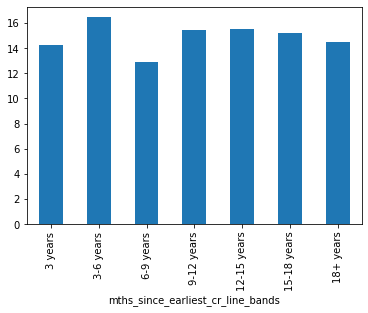

In [353]:
cop = get_charged_off_percent(df.groupby('mths_since_earliest_cr_line_bands'))
cop.plot.bar()
cop

### Income Verification Status VS Charged Off Loan Percentage
Loans for which borrowers income was verified by LC interestingly have much higher charged off percentage than not verified.

verification_status
Not Verified       12.709053
Source Verified    15.302752
Verified           18.146269
dtype: float64

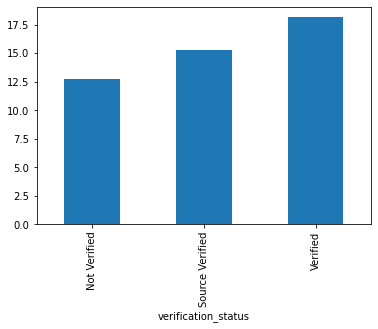

In [354]:
cop = get_charged_off_percent(df.groupby('verification_status'))
cop.plot.bar()
cop

### Income Verification Status VS Loan Amount
Having verified income by LC itself might not impact the charged off loans percentage but based on below analysis we can see that the verified loans are funded much higher amounts. higher loan amounts are known to be more risky than others.

<AxesSubplot:xlabel='loan_amnt', ylabel='verification_status'>

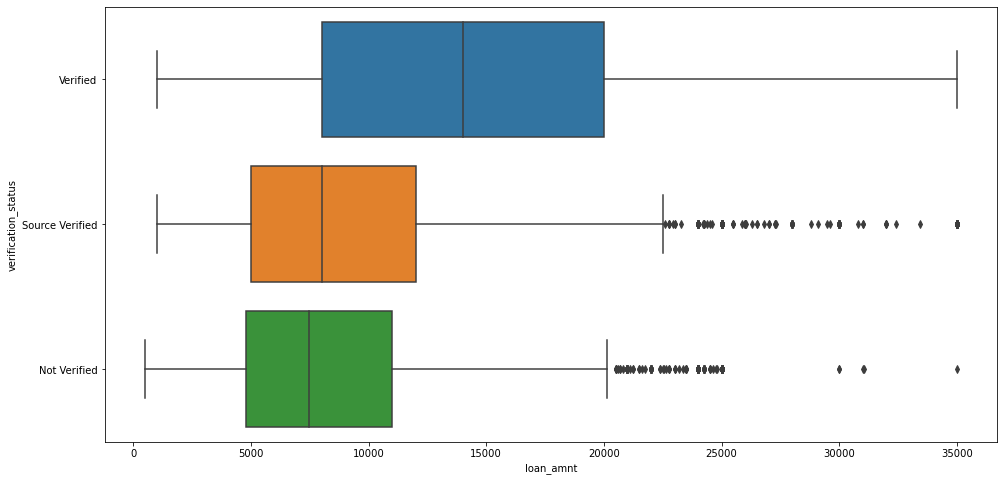

In [355]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='loan_amnt', y='verification_status', data=df, ax=ax)

### Income Verification Status VS Interest Rate
Having verified income by LC itself might not impact the charged off loans percentage but based on below analysis we can see that the verified loans are funded at higher interest rates. higher interest rate loans are known to be more risky than others.

<AxesSubplot:xlabel='int_rate', ylabel='verification_status'>

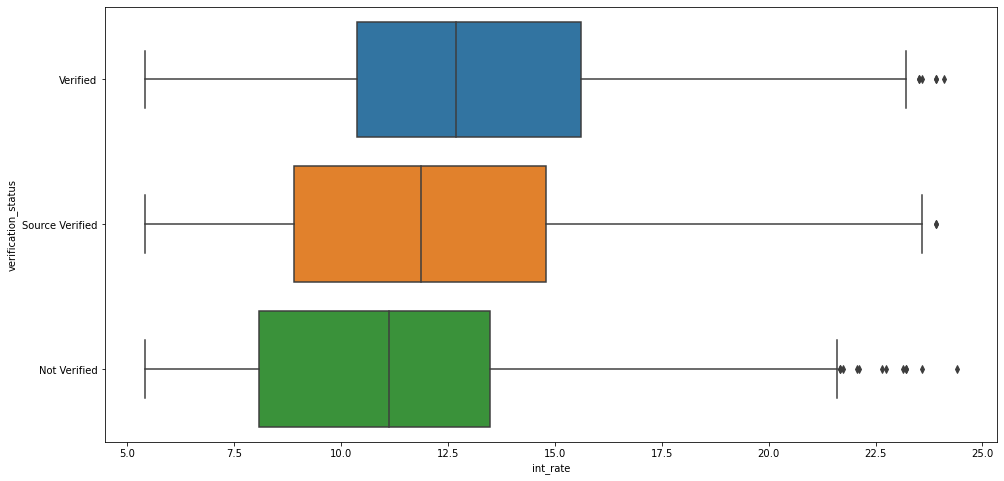

In [356]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='int_rate', y='verification_status', data=df, ax=ax)

### Loan Grade VS Charged Off Loan Percentage
As expected the charged off loans percentage increases with the decreasing grade issued by LC. This indicated the grading system in working correctly.

grade
A     6.243423
B    12.666936
C    17.731990
D    22.469541
E    27.819905
F    34.366577
G    39.500000
dtype: float64

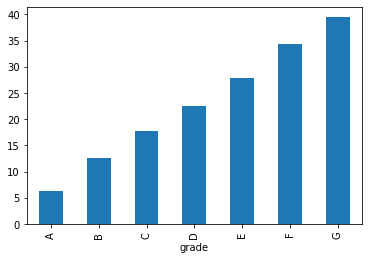

In [357]:
cop = get_charged_off_percent(df.groupby('grade'))
cop.plot.bar()
cop

### Loan Grade VS Interest Rate
The interest rate increases linearly with descrease in loan quality based on the grade assigned by LC.

<AxesSubplot:xlabel='grade', ylabel='int_rate'>

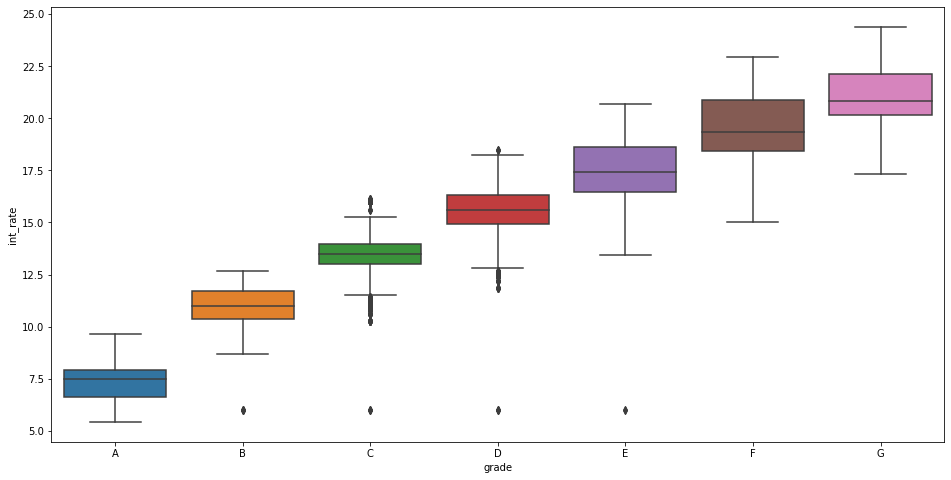

In [358]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x='grade', y='int_rate', data=df.sort_values('grade'), ax=ax)

## Multivariate Analysis
Further analysis taking multiple variables at once into considerartion.

### Loan Amount VS Annual Income VS Interest Rate VS Debt to Income
- Charged off loan percentage at higher interest rates is high irrespective of other factors.
- Higher loan amount at lower annual income has higher charged off loan percentage.
- Higher loan amount at higher debt to income ratio has higher charged off loan percentage.

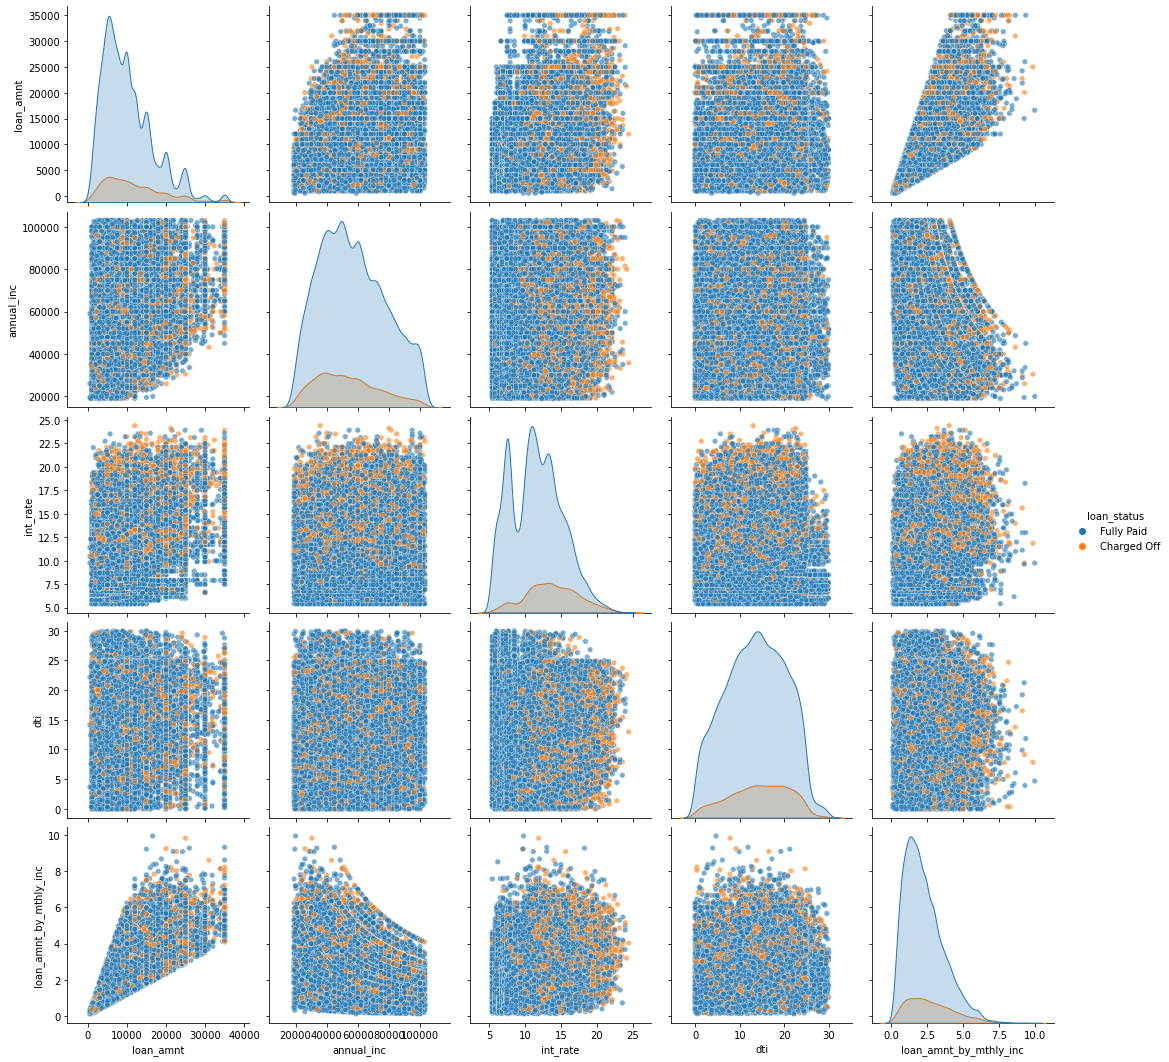

In [359]:
df_pair = df[['loan_amnt', 'annual_inc', 'int_rate', 'dti', 'loan_amnt_by_mthly_inc', 'loan_status']].copy()

# Create a pair plot colored by loan status with a density plot of the # diagonal and format the scatter plots.
sns.pairplot(df_pair,
             hue='loan_status',
             diag_kind="kde",
             plot_kws={
                 'alpha': 0.6,
                 's': 30,
                 'edgecolor': 'white'
             },
             size=3)
plt.show()

### Debt to Income VS Loan Purpose Vs Charged Off Loan Percentage
- Small Business loans are highly risky irrespective of the monthly debt payments of the borrowers.
- Medical and educational loans are risky when the borrowers is already paying 20-30 percent of monthly income on debt obligations other than the LC loan.

In [360]:
find_outlying_charged_off_prcnt_groups(df, ['dti_bands', 'purpose'])

dti_bands      purpose         
10-20 percent  small_business      31.634446
               renewable_energy    29.729730
20-30 percent  small_business      28.260870
0-10 percent   small_business      26.040062
20-30 percent  educational         24.000000
               medical             21.111111
dtype: float64

### 20-30 Percent Debt to Income VS Loan as Percentage of Monthly Income VS Charged Off Loan Percentage

loan_amnt_by_mthly_inc_bands
< 1 month     14.434060
1-3 months    13.882995
3-6 months    21.597096
6+ months     33.734940
dtype: float64

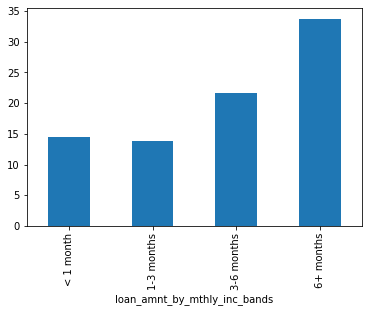

In [361]:
get_charged_off_percent(df[df.dti_bands == '20-30 percent'].groupby(['loan_amnt_by_mthly_inc_bands'])).plot.bar()
get_charged_off_percent(df[df.dti_bands == '20-30 percent'].groupby(['loan_amnt_by_mthly_inc_bands']))

### Interest Rate VS Loan Purpose VS Charged Off Loan Percentage
- Small Business loans are highly risky irrespective of interest rate.
- Educational, House, Car, Debt Consolidation, and Moving loans are highly risky when the interest rates > 17%.

In [362]:
find_outlying_charged_off_prcnt_groups(df, ['int_rate_bands', 'purpose'])

int_rate_bands  purpose           
17+ percent     educational           50.000000
                small_business        44.495413
                house                 39.393939
                car                   38.095238
                debt_consolidation    34.454829
11-14 percent   small_business        32.439678
17+ percent     moving                31.250000
                other                 31.018519
14-17 percent   small_business        30.721003
dtype: float64

### Loan Amount VS Loan Purpose VS Charged Off Loan Percentage
- Medical loans > 25K are highly risky.
- Educational loans > 20K are highly risky.
- Vacation loans > 15K are highly risky.

In [363]:
find_outlying_charged_off_prcnt_groups(df, ['loan_amnt_bands', 'purpose'])

loan_amnt_bands  purpose           
25k+             medical               50.000000
                 small_business        46.913580
20k-25k          educational           40.000000
15k-20k          vacation              40.000000
20k-25k          small_business        34.931507
15k-20k          small_business        34.146341
20k-25k          vacation              33.333333
                 renewable_energy      33.333333
                 car                   33.333333
10k-15k          small_business        32.624113
25k+             debt_consolidation    27.676768
dtype: float64

### 60 Months Term Loans VS Loan Purpose VS Charged Off Loan Percentage
Small business and educational loans of 60 months are even more risky than other 60 months loans

In [364]:
find_outlying_charged_off_prcnt_groups(df[df.term_months == 60], ['purpose'])

purpose
small_business    43.269231
educational       40.000000
dtype: float64

### Employment Length VS Loan Purpose VS Charged Off Loan Percentage
- Educational, credit card, wedding and debt_consolidation loans for borrowers having no or <1 year employment length record are highly risky.
- Small business loans irrespective of employment length are highly risky.

In [365]:
find_outlying_charged_off_prcnt_groups(df, ['emp_length_bands','purpose'])

emp_length_bands  purpose           
0 years           educational           66.666667
                  small_business        35.294118
                  moving                33.333333
10+ years         small_business        31.640625
4-6 years         small_business        29.841270
< 1 year          small_business        28.421053
1-3 years         small_business        26.539278
0 years           credit_card           26.415094
< 1 year          vacation              26.086957
6-9 years         small_business        25.342466
0 years           wedding               25.000000
1-3 years         renewable_energy      25.000000
6-9 years         vacation              23.684211
                  moving                23.529412
0 years           debt_consolidation    23.151125
< 1 year          educational           23.076923
6-9 years         house                 22.857143
dtype: float64

### Small Business Loans Interest Rates VS Charged Off Loan Percentage

int_rate_bands
5-8 percent      11.297071
8-11 percent     22.813688
11-14 percent    32.439678
14-17 percent    30.721003
17+ percent      44.495413
dtype: float64

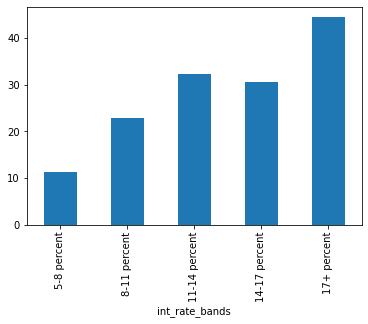

In [366]:
get_charged_off_percent(df[df.purpose == 'small_business'].groupby(['int_rate_bands'])).plot.bar()
get_charged_off_percent(df[df.purpose == 'small_business'].groupby(['int_rate_bands']))

### Educational Loan Amount as Percentage of Monthly Income VS Charged Off Loan Percentage

loan_amnt_by_mthly_inc_bands
< 1 month     10.958904
1-3 months    19.083969
3-6 months    20.512821
6+ months      0.000000
dtype: float64

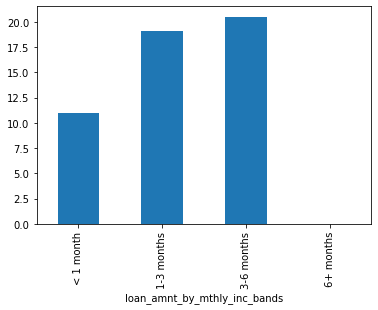

In [367]:
get_charged_off_percent(df[df.purpose == 'educational'].groupby(['loan_amnt_by_mthly_inc_bands'])).plot.bar()
get_charged_off_percent(df[df.purpose == 'educational'].groupby(['loan_amnt_by_mthly_inc_bands']))

### Loan Amount as Percentage of Monthly Income VS Annual Income VS Charged Off Loan Percentage

In [368]:
get_charged_off_percent(df.groupby(['loan_amnt_by_mthly_inc_bands','annual_inc_bands']))

loan_amnt_by_mthly_inc_bands  annual_inc_bands
< 1 month                     0-20k               18.750000
                              20k-40k             15.961945
                              40k-60k             13.225446
                              60k-80k             10.542732
                              80k-100k             8.726625
                              100k+                4.225352
1-3 months                    0-20k               11.111111
                              20k-40k             15.500463
                              40k-60k             13.102028
                              60k-80k             11.686829
                              80k-100k            10.903659
                              100k+               10.396040
3-6 months                    0-20k               12.711864
                              20k-40k             20.724346
                              40k-60k             20.156091
                              60k-80k             20.

### 2+ Times Inquiries Borrowers Loan Amount VS Charged Off Loan Percentage

In [369]:
get_charged_off_percent(df[df.inq_last_6mths_bands == '2+ times'].groupby(['loan_amnt_bands']))

loan_amnt_bands
0-5k       19.148936
5k-10k     19.274809
10k-15k    20.508167
15k-20k    25.806452
20k-25k    28.313253
25k+       38.888889
dtype: float64

##  Summary
Synopsis of the above analysis

The Lending Club dataset contains a lot of variables which tells us about the kind of loan taken and borrower's past transactions. In our analysis we have used this data to find what variables out of all creates an impact on whether the loan is fully repaid or defaulted.

We started from clearning the data, picking the right columns, filling null values and more. For the selected variables we performed univariate analysis by analyzing the spread of quantitative metrics and forming bands for each of them. For qualitative variables we did frequency plotting.

After analysing the spread of variables we performed Bivariate analysis to find relation between various variables and charged off loan percentages. Based on the initial results we did further detailed study in multivariate analysis.

We also did correlation study and pair plotting and found interesting insights.

### Variables Impacting Loan Default Percentage
- Loan Ammount
- Annual Income
- Interest Rate
- Instalment Amount
- Loan Purpose
- Debt to Income
- Inquiries in Last 6 Months
- Employment Length

### Loan Amount
- Higher the loan amount, higher the charged off loan percentage. Upto 27% for 25k+ loans.
- 75% of applications apply for loan amounting < 15K
- Most of the borrowers take loans upto 1-3 months of their income. Loans amounting to > 6 months of borrowers income has a much higher charged off loan percentage i.e. 32%.
- Most defaulters do not pay 50-85% of the loan principal amount.
- Strongly co-related with annual income. higher amounts are funded to people with higher annual income.

### Annual Income
- Annual income in the range of 20K-40K has the most charged off loans percentage i.e. 17.75%.
- Contained a lot of outliers having very large amount of annual income which skewed all the plottings due to which they were removed based on IQR.
- Most borrowers have income in the range of 40K-70K.
- It slightly co-relates with the employment length.
- Higher loan amount at lower annual income has higher charged off loan percentage.

### Interest Rate
- Charged off loans percentage increases rapidly with increase in interest rates. Loans with 17%+ interest rates have 33% defaulter rate.
- Charged off loan percentage at higher interest rates is high irrespective of all other factors.
- Most of the loans are funded at the interest rate of 8-14%, while the interest rate goes as high as 24%.
- Higher amount loans have higher interest rates.
- Educational, House, Car, Debt Consolidation, and Moving loans are highly risky when the interest rates > 17%.

### Instalment Amount
- For most people instalment amount is < 300.
- Most people pay 4-9 percent of their monthly income as instalments.
- Loans with monthly instalment amount > 600 are at a higher risk of delinquency with charged off loan percentage being 18.88%. 
- The charged off loan percentage increases linearly with increase in monthly installment amount.
- Borrowers paying 15-20 percent of their monthly income as instalment are more likely to not be able to repay their loans with charged off loan percentage being 21.69%.

### Loan Purpose
- Small business loans have the higher defaulter rate i.e. 28.5% irrespective of all other factors.
- For defaulted loans, house, small business and wedding loans have the higher percentage of principal amount not paid back.
- Medical and educational loans are risky when the borrowers are already paying 20-30 percent of monthly income on debt obligations other than the LC loan.
- The most popular purpose for loans is debt consolidation followed by credit card. While small business, house, debt consolidation loans have the highest average loan amount overall.

### Debt to Income
- Most borrowers spend 8-18% of their monthly income into debt obligations other than the LC loan.
- Borrowers having already paying 20-30 percent of their monthly income as other debt obligations are slightly at more risk of defaulting.
- The charged off loan percentage increases slightly with increase in debt to income.
- People with higher debt to income takes loans of slightly higher amount.
- People spend 30-40 percent of their monthly income into debt obligations including LC loan are at high risk of deliquency.
- Higher loan amount at higher debt to income ratio has higher charged off loan percentage.

### Employment Length
Assuming null records have 0 years of employment length
- Most borrowers have 1-3 years of employment length.
- Employment length slightly co-relates with annual income.
- People with 0 years of employment have the highest charged off loan rate i.e. 21.77%.
- Borrowers having no employment length record are known to be highly risky even when it can be seen that they are provided small amount loans at lower interest rates than others.
- Educational, credit card, wedding and debt_consolidation loans for borrowers having no or <1 year employment length record are highly risky.

### Inquiries in Last 6 Months
- Most people do 1 or fewer inquiries. 
- People who do more than 2 inquiries have a much higher defaulter rate at 21%.

## Recommendations
For lowering the defaulter ratio following are the recommendations.

- Loan amounts greater than 6 months of borrower's income when their monthly income is more than 20K are highly risky. It is recommended not to provide such loans at all as the defaulter rate for such loans is up to 36%.
- Small Business loans funded at an interest rate of more than 8% are highly risky. The ones given at 5-8% interest rate have a healthy defaulter rate. It is recommended to give business loans at lower rates so that borrowers can focus and grow their business and have the ability to repay the loans.
- Educational loans where the total amount is more than 3 months of the borrower's monthly income are highly risky with a defaulter rate of 20%. It is recommended to fund smaller amounts of loans for education purposes.
- Borrowers who have made 2+ times inquiries in the past for loans amounting to more than 20K are at high risk of not repaying the loan. It is recommended to give lower amounts of loans to such people.
- When the debt to income for the borrowers is already 20-30 per cent, the loans amounting to 3+ months of borrowers’ monthly income are highly risky as the defaulter rate goes up to 33.73%. It is recommended to only give small amounts of loans to such people.
- Medical and educational loans are risky when the borrowers are already paying 20-30 per cent of monthly income on debt obligations other than the LC loan. It is recommended to give small loans in such cases.